In [1]:
import collections
import math
import string
import logging
import numpy as np
import pandas as pda
from itertools import permutations
from sympy.utilities.iterables import partitions
import matplotlib.pyplot as plt 

pda.set_option('precision', 10)
%matplotlib inline

# Functions

**Test Variables**

In [4]:
## Number of unique diseases possible
k = 3

## Priors
pi = [1/2, 1/3, 1/6]
pi_uni = [1/3, 1/3, 1/3]
pi_close = [1/2, 1/4, 1/4]

## Integer Partitions
### n = 6
pa = {3:1, 2:1, 1:1}
pb = {3:2}
pc = {6:1}
pd = {4:1, 1:2}
ph = {4:1, 2:1}
pg = {5:1, 1:1}

prior_test = pi
partition_test = pa

---
**k_dictionary**

Input: pi, the probability distribution

Output: a dictionary with letters for keys. The letters represent individual diseases. Can be used to keep track of individual diseases throughout the gain function calculations.

```python
pi = [1/2, 1/3, 1/6]
k_dict = {'a': 0.5, 'b': 0.33333, 'c':0.166666}
```

In [2]:
def k_dictionary(pi):
    return dict(zip(string.ascii_lowercase, pi))

In [6]:
my_pi_dict = k_dictionary(prior_test)

print(my_pi_dict)

{'a': 0.5, 'b': 0.3333333333333333, 'c': 0.16666666666666666}


---
**list_all_ints** is a helper function to type_probability

Input: the integer partition dictionary

Output: a list of the integers

```python
p = {3:1, 1:2}
col_names = [3, 1, 1]
```

In [3]:
def list_all_ints(p):
    col_names = []
    for i in p.keys(): # i = integer, m = multiplicity
        m = p[i]
        for x in range(m):
            col_names.append(i)
    return col_names

---
**type_3** calculates all possible probabilies for each column type, given an integer partition

Input: 
- an integer partition p 
- pi_dict, a dictionary of diseases and probabilities in k 
- k, the number of unique plaintext values/diseases

```python
p = {6:1}
pi_dict = {'a': 0.5, 'b': 0.33333, 'c':0.166666}
k = 3
```

Output:
- df: columns represent the different blocks. Each row has a different permutation of diseases. The final column is the probability of that particular column type occuring
- int_list: the expanded form of the integer partition

Notes: 
- hardcoded for k = 3
- uses list_all_ints(p) as a helper function. 

In [4]:
def type_3(p, pi_dict, k):
    int_list = list_all_ints(p)
    int_list_len = len(int_list)
    data = list(permutations(pi_dict.keys(), min(k, int_list_len)))
    df = pda.DataFrame(data = data, columns=int_list)
    if int_list_len == 1:
        df['prob']= pow(df.iloc[:,0].map(pi_dict), df.columns.values[0])
    elif int_list_len == 2:
        df['prob']= pow(df.iloc[:,0].map(pi_dict), df.columns.values[0]) * pow(df.iloc[:,1].map(pi_dict), df.columns.values[1])
    elif int_list_len == 3:
        df['prob']= pow(df.iloc[:,0].map(pi_dict), df.columns.values[0]) * pow(df.iloc[:,1].map(pi_dict), df.columns.values[1]) * pow(df.iloc[:,2].map(pi_dict), df.columns.values[2])
    elif int_list_len == 4:
        df['prob']= pow(df.iloc[:,0].map(pi_dict), df.columns.values[0]) * pow(df.iloc[:,1].map(pi_dict), df.columns.values[1]) * pow(df.iloc[:,2].map(pi_dict), df.columns.values[2]) * pow(df.iloc[:,3].map(pi_dict), df.columns.values[3])
    elif int_list_len == 5:
        df['prob']= pow(df.iloc[:,0].map(pi_dict), df.columns.values[0]) * pow(df.iloc[:,1].map(pi_dict), df.columns.values[1]) * pow(df.iloc[:,2].map(pi_dict), df.columns.values[2]) * pow(df.iloc[:,3].map(pi_dict), df.columns.values[3]) * pow(df.iloc[:,4].map(pi_dict), df.columns.values[4])
    else:
         raise ValueError("The integer partition doesn't make sense")
    return df, int_list

In [15]:
my_df, my_int_list = type_3(partition_test, my_pi_dict, k)
my_df

,3,1,1,prob
0,a,b,c,0.0069444444
1,a,c,b,0.0069444444
2,b,a,c,0.0030864198
3,b,c,a,0.0030864198
4,c,a,b,0.0007716049
5,c,b,a,0.0007716049


In [32]:
my_df['prob'].sum(axis=0)

0.035493827160493825

---
***choices_matrix()*** provides a matrix listing all the choices for a given integer partition and prior pi

Input:
- df: the dataframe with all possible types for the integer partition
- int_list: the expanded integer partition

Output:
- df_g, or dataframe_guess, a matrix with the (not normalized) probabilities of every possible block in the integer partition being a particular disease.


In [5]:
def choices_matrix(df, int_list):
    df_g = pda.DataFrame(0, index=int_list, columns=['a','b','c'])
    col = 0
    for i in int_list:
        df_g.loc[i,'a'] = df[df.iloc[:,col] == 'a']['prob'].sum()
        df_g.loc[i,'b'] = df[df.iloc[:,col] == 'b']['prob'].sum()
        df_g.loc[i,'c'] = df[df.iloc[:,col] == 'c']['prob'].sum()
        col = col + 1
    return df_g

In [6]:
def choices_matrix_4(df, int_list):
    df_g = pda.DataFrame(0, index=int_list, columns=['a','b','c','d'])
    col = 0
    for i in int_list:
        df_g.loc[i,'a'] = df[df.iloc[:,col] == 'a']['prob'].sum()
        df_g.loc[i,'b'] = df[df.iloc[:,col] == 'b']['prob'].sum()
        df_g.loc[i,'c'] = df[df.iloc[:,col] == 'c']['prob'].sum()
        df_g.loc[i,'d'] = df[df.iloc[:,col] == 'd']['prob'].sum()
        col = col + 1
    return df_g

In [7]:
def choices_matrix_5(df, int_list):
    df_g = pda.DataFrame(0, index=int_list, columns=['a','b','c','d','e'])
    col = 0
    for i in int_list:
        df_g.loc[i,'a'] = df[df.iloc[:,col] == 'a']['prob'].sum()
        df_g.loc[i,'b'] = df[df.iloc[:,col] == 'b']['prob'].sum()
        df_g.loc[i,'c'] = df[df.iloc[:,col] == 'c']['prob'].sum()
        df_g.loc[i,'d'] = df[df.iloc[:,col] == 'd']['prob'].sum()
        df_g.loc[i,'e'] = df[df.iloc[:,col] == 'e']['prob'].sum()
        col = col + 1
    return df_g

In [19]:
# Test of choices_matrix() w/type 4
my_df_guess = choices_matrix(my_df, my_int_list)
my_df_guess

,a,b,c
3,0.0138888889,0.0061728395,0.0015432099
1,0.0038580247,0.0077160494,0.0100308642
1,0.0038580247,0.0077160494,0.0100308642


In [20]:
norm = my_df_guess.div(my_df_guess.sum(axis=1), axis = 0)
norm

,a,b,c
3,0.6428571429,0.2857142857,0.0714285714
1,0.1785714286,0.3571428571,0.4642857143
1,0.1785714286,0.3571428571,0.4642857143


---
***forced_max()*** takes the matrix of possible guesses and calculates the posterior g vuln under the 'forced' gain function.

- For every block, it finds the max value (across the row)
- Weighs the max value by the a proportional number of outputs


<img src="forced_max.png" alt="drawing" width="400"/>

In [8]:
def forced_max(df_g, num_index, n):
    total = -1
    df_block_max = df_g.max(axis=1)
    index_list = list(df_block_max.index.values)
    perc = [x / n for x in index_list]
    vec = [x * num_index for x in perc]
    total = df_block_max.mul(vec).sum(axis=0)
    return total

In [16]:
my_num_index = 15
total = forced_max(my_df_guess, my_num_index, 6)
print("total: ", total)

total:  0.048546810699588466


---
***choose_max()*** takes the reduced matrix and says which guess to make, along with the posterior vulnerability the integer partition provided

Input:
- df_reduced_guess, the reduced matrix of choices

Output:
- val, the contribution to the posterior vulnerability for one instance of one integer partition
- block_size, the block to guess about
- disease, the correct disease, or plaintext value, to guess

In [9]:
def choose_max(df_reduced_guess):
    col_max_values = df_reduced_guess.max() # per column, the max values
    col_max_values_id = df_reduced_guess.idxmax() # per column (disease), the index/block size of the max values
    val = col_max_values.max() # max of the column maximums
    disease = col_max_values.idxmax() # disease (column) of the above value
    block_size = col_max_values_id.loc[disease] # contribution to the posterior vuln by this integer partition
    return val, block_size, disease

In [18]:
my_val, my_block, my_disease = choose_max(my_df_guess)
print("contribution of partition to posterior vuln: ", my_val)
print("*********The best choice is*********")
print("block size: ", my_block)
print("disease: ", my_disease)

contribution of partition to posterior vuln:  0.003858024691358024
*********The best choice is*********
block size:  1
disease:  c


<IPython.core.display.Javascript object>


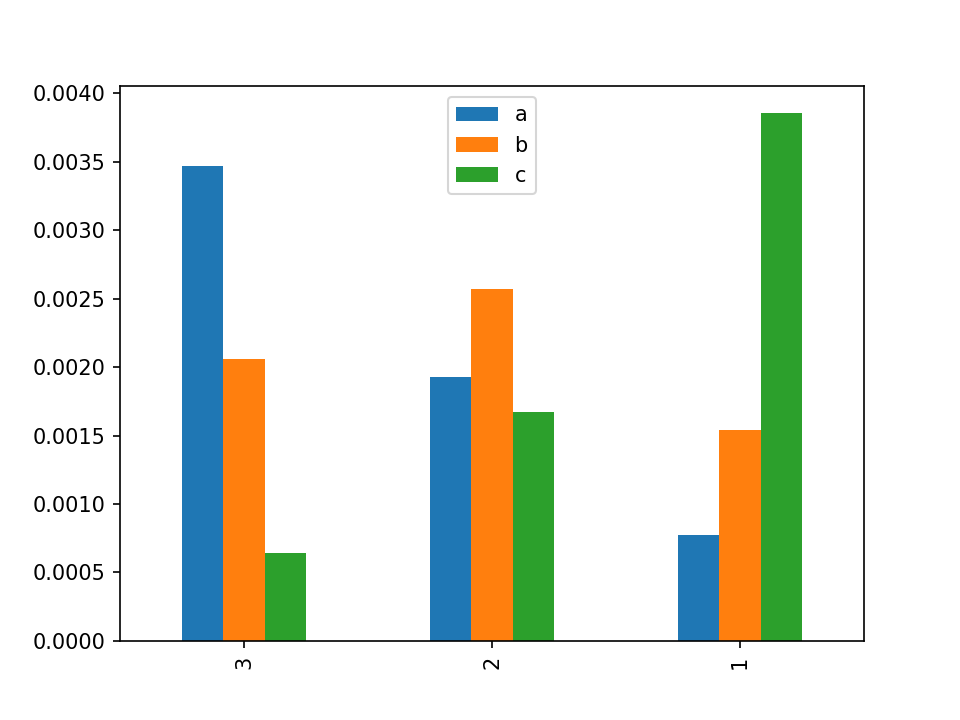

In [19]:
my_reduced_df.plot.bar()

---
**calc_index_partitions()** calculates number of index partitions given an integer n and a integer partition p

Input:
- n: positive integer, the size of the column
- p: a unique integer partition, as a python dictionary

Output:
- frac: the number of index partitions that can have integer partition p

Generalized formula:<br>
With an interger partition $p$ containing integers $i$, each with multiplicity of $m$,
$$\text{index partitions}(n,p)=\frac{n!}{\prod_{i \in p} i!^m m!}$$

Example:<br>
$$\text{index partitions}(6,\{4:1, 1:2\}) = \frac{6!}{\left(4!\right)1! \times \left(1!\right)^2 2!} $$

In [10]:
def calc_index_partitions(n,p):
    num = math.factorial(n)
    den = 1
    mul = 0
    for i in p.keys():
        mul = p[i]
        den = den * pow(math.factorial(i), mul) * math.factorial(mul)
    num_index = num / den
    return num_index

# Normalized Functions and Graphs

***normalized_choose_post_vuln()*** provides the normalized, per integer partition probability for the 'choose' gain function. 

The following graphic demonstrates the program's flow. 

Functions are represented as rectangles while variables are ovals. 

The light purple backgrounds indicates functions that occur in the per-integer partition loop.

The black variable is the per-integer partition normalized posterior vulnerability for the choose gain function.

<img src="norm_flow.png" alt="drawing" width="600"/>

In [17]:
def normalized_choose_post_vuln(n, k, pi): #does not return a dataframe w/every partition
    data = []
    pi_dict = k_dictionary(pi) # the dictionary of diseases and probabilies {a:1/2, b:1/3, etc.}
    for p in partitions(n, m=k): 
        p_guess = {}
        num_index = calc_index_partitions(n,p) # p's number of index partitions
        df, int_list = type_3(p, pi_dict, k) # the probabilities of different types of the column
        logging.info('dataframe -\n {}'.format(df))
        single_outer = df['prob'].sum(axis=0)
        outer = single_outer * num_index
        if k == 3:
            df_g = choices_matrix(df, int_list) # the disease:block size guesses the adversary can make
        elif k == 4:
            df_g = choices_matrix_4(df, int_list)
        elif k == 5:
            df_g = choices_matrix_5(df, int_list)
        else:
            raise ValueError("k isn't 3, 4, or 5")
        logging.info('Guess Matrix -\n {}'.format(df_g))
        norm = df_g.div(df_g.sum(axis=1), axis = 0)
        inner, block_size, disease = choose_max(norm)#posterior vuln for 1 p and best guess
        int_list += [0] * (3 - len(int_list)) #pad int_list
        p_guess = {'partition': int_list, 'num_index': num_index, 'inner': inner, 'outer':outer, 'block': block_size, 'disease': disease, 'first': int_list[0], 'second': int_list[1], 'third': int_list[2]}
        data.append(p_guess)
    partition_df = pda.DataFrame(data = data)
    prob_df = partition_df.sort_values(by=['inner'], ascending=False).reset_index(drop=True)
    return prob_df

In [22]:
n = 50
k = 3
prob_df= normalized_choose_post_vuln(n, k, [1/2, 1/3, 1/6])
prob_df

,block,disease,first,inner,num_index,outer,partition,second,third
0,50,a,50,0.9999999984,1.0000000000e+00,8.8817842109e-16,"[50, 0, 0]",0,0
1,49,a,49,0.9999999969,5.0000000000e+01,4.4408921124e-14,"[49, 1, 0]",1,0
2,48,a,48,0.9999999947,1.2250000000e+03,4.8356380884e-13,"[48, 1, 1]",1,1
3,48,a,48,0.9999999929,1.2250000000e+03,6.0445476212e-13,"[48, 2, 0]",2,0
4,47,a,47,0.9999999894,5.8800000000e+04,1.1605531474e-11,"[47, 2, 1]",2,1
5,47,a,47,0.9999999835,1.9600000000e+04,5.8027657709e-12,"[47, 3, 0]",3,0
6,46,a,46,0.9999999821,6.9090000000e+05,6.0606664803e-11,"[46, 2, 2]",2,2
7,46,a,46,0.9999999762,9.2120000000e+05,1.0101110861e-10,"[46, 3, 1]",3,1
8,45,a,45,0.9999999643,2.1187600000e+07,9.2930221025e-10,"[45, 3, 2]",3,2
9,46,a,46,0.9999999617,2.3030000000e+05,4.2929721779e-11,"[46, 4, 0]",4,0


In [23]:
prob_df['num_index'].sum(axis=0)

1.1964966461530876e+23

## Graph Functions for Normalized Values

In [12]:
def to_str(var):
    return str(list(np.reshape(np.asarray(var), (1, np.size(var)))[0]))[1:-1]

In [35]:
def graph_choose_normalized_index(n, k, probs, df):
    fig, ax = plt.subplots()

    df2 = df[['num_index']]
    df2.plot(kind='bar', stacked=True, ax = ax)
    ax2 = ax.twinx()
    
    df.reset_index().plot.scatter(ax = ax2,
                                  x='index',
                                  y='inner',
                                  c = 'purple',
                                  marker = 'o',
                                  figsize=(15,10))
    
    ax2.set_ylim(bottom=0, top = 1)
    #ax.set_ylim(bottom=0, top = n)
    ax.set_xticks(df.index)
    ax.set_xticklabels(df['partition'], rotation=90)
    ax.get_legend().remove()
    plt.show()
    plt.close()

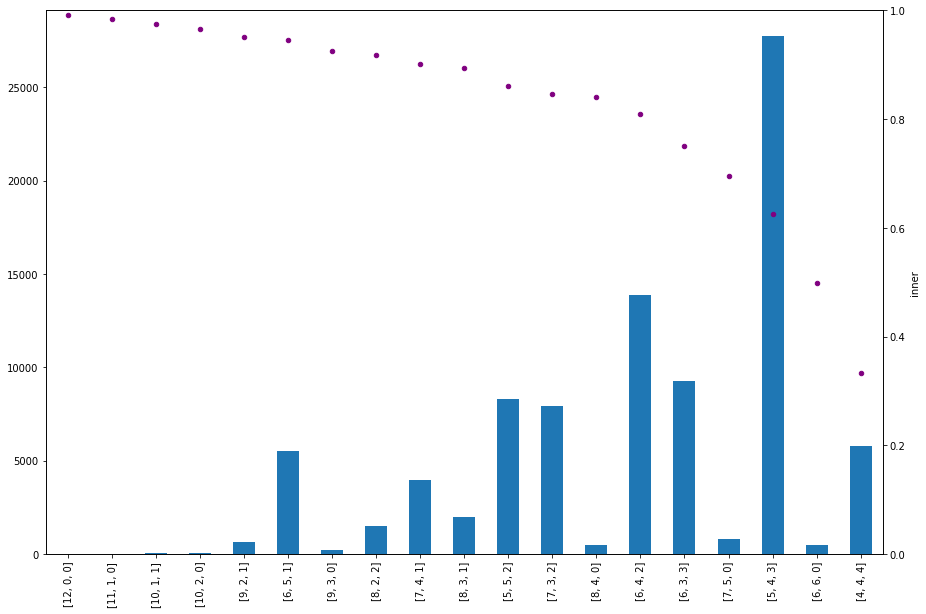

In [36]:
n = 12
k = 3
prob = [1/2, 1/3, 1/6]
norm_df = normalized_choose_post_vuln(n, k, prob)
graph_choose_normalized_index(n, k, prob, norm_df)

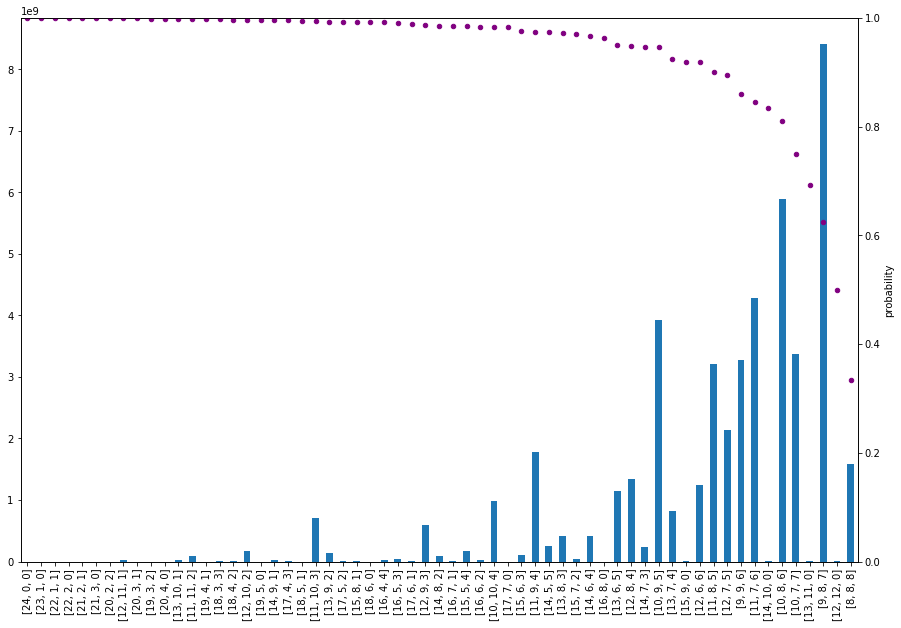

In [14]:
n = 24
k = 3
prob = [1/2, 1/3, 1/6]
norm_df = normalized_choose_post_vuln(n, k, prob)
graph_choose_normalized_index(n, k, prob, norm_df)

In [37]:
def graph_choose_normalized(n, k, probs, df):
    df.reset_index().plot.scatter(x='index', 
                y='inner', figsize=(15,10))
    plt.xticks(df.index, df['partition'], rotation=90)
    plt.ylim(bottom=0, top = 1)
    # title rounds the prior
    format_probs = ['%.3f' % prob for prob in probs]
    plt.title(f'k = {k}, prior = {format_probs}')
    plt.legend()
    plt.show()
    plt.close()

In [38]:
def graph_choose_normalized_blocksize(n, k, probs, df):
    fig, ax = plt.subplots()

    df2 = df[['first', 'second', 'third']]
    df2.plot(kind='bar', stacked=True, ax = ax)
    ax2 = ax.twinx()
    
    df.reset_index().plot.scatter(ax = ax2,
                                  x='index',
                                  y='inner',
                                  c = 'purple',
                                  marker = 'o',
                                  figsize=(15,10))
    
    ax2.set_ylim(bottom=0, top = 1)
    ax.set_ylim(bottom=0, top = n)
    ax.set_xticks(df.index)
    ax.set_xticklabels(df['partition'], rotation=90)
    ax.get_legend().remove()
    plt.show()
    plt.close()

In [32]:
def graph_choose_normalized_blocksize_annotate(n, k, probs, df):
    # Create 3 axeses 
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax3 = ax.twinx()

    # Stacked bar graph
    df2 = df[['first', 'second', 'third']]
    df2.plot(kind='bar', stacked=True, ax = ax, color=['#aec7e8','#ffbb78', '#98df8a'])
    ax.set_ylabel('block size')
    ax.get_legend().remove()
    
    # Outer probability line
    df = df.reset_index()
    df.plot(ax = ax3,
            x = 'index',
           y = 'outer')
    ax3.get_legend().remove()
    
    # Normalized vuln in scatter plot
    df.plot.scatter(ax = ax2,
                    x='index',
                    y='inner',
                    c = 'darkslategrey',
                    marker = 'o',
                    figsize=(15,10))
    for key, row in df.iterrows():
        dis = to_str(df['disease'][key])
        dis = dis.replace("'", "")# .capitalize()
        block = to_str(df['block'][key])
        if len(block) < 2:
            block = " " + block
        text = dis + ","+ block
        ax2.annotate(text,
                    xy=(row['index'], row['inner']),
                    ha='center',
                    va='center',
                    family='sans-serif', fontsize=12, color='white',
                    bbox=dict(facecolor='tab:purple', edgecolor='tab:purple', boxstyle='circle') # #c5b0d5
                    )
    
    # Set Probability axis 0-1
    ax2.set_ylim(bottom=0, top = 1)
    ax2.set_ylabel('probability')
    
    ax.set_ylim(bottom=0, top = n)
    ax3.set_ylim(bottom=0, top = 1)
    ax.set_xticks(df.index)
    ax.set_xticklabels(df['partition'], rotation=90)
    ax.set_xlabel('integer partitions')
    plt.title("Posterior g-vulnerability where n = 12")
    plt.show()
    plt.close()

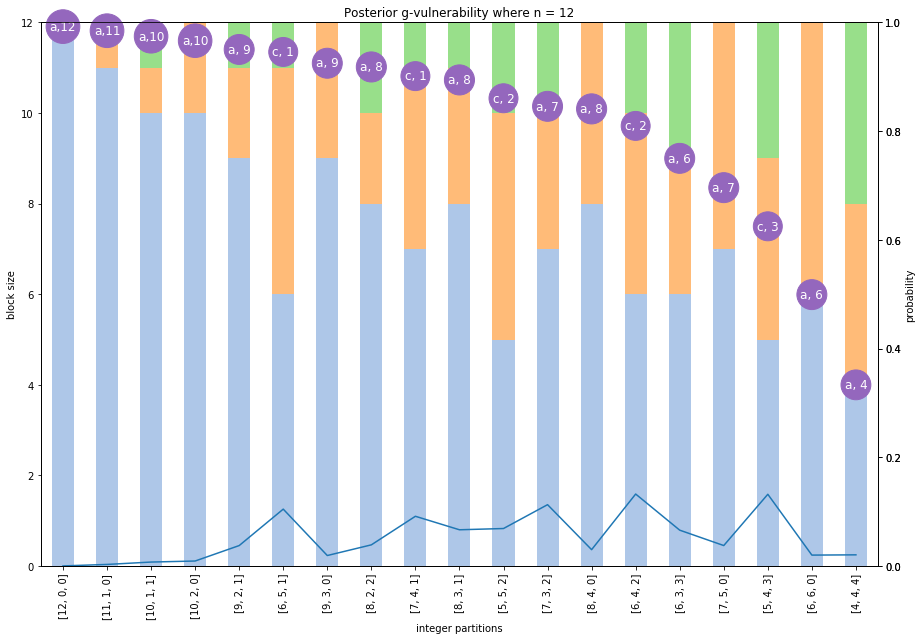

In [33]:
n = 12
k = 3
prob = [1/2, 1/3, 1/6]
norm_df = normalized_choose_post_vuln(n, k, prob)
graph_choose_normalized_blocksize_annotate(n, k, prob, norm_df)

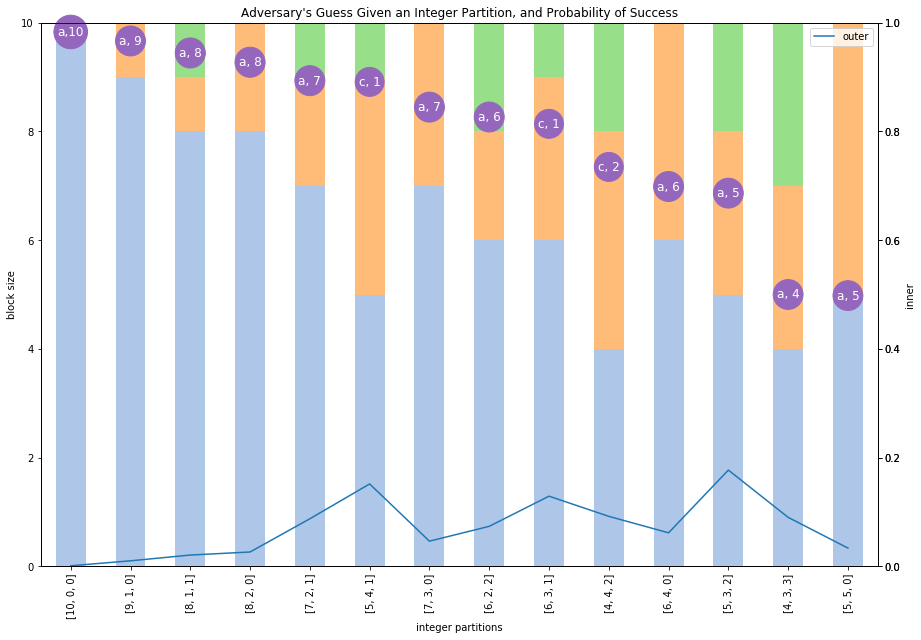

In [61]:
n = 10
k = 3
prob = [1/2, 1/3, 1/6]
norm_df = normalized_choose_post_vuln(n, k, prob)
graph_choose_normalized_blocksize_annotate(n, k, prob, norm_df)

In [66]:
logging.disabled = True

In [22]:
def graph_choose_normalized_annotate(n, k, probs, df):
    fig, ax = plt.subplots() 
    df.reset_index().plot.scatter(x='index', 
                y='probability', ax = ax, figsize=(15,10))
    #annotate with disease and block choice
    for  ind, v in df.iterrows():
        dis = to_str(df['disease'][ind])
        block = to_str(df['block'][ind])
        dis = dis.replace("'", "").capitalize()
        text = block + " : " + dis
        ax.annotate(text,
                     xy=(ind, v['probability']),
                     xytext=(-10,10), textcoords='offset points',
                     family='sans-serif', fontsize=14, color='darkslategrey')
    
    #format graph
    plt.xticks(df.index, df['partition'], rotation=90)
    plt.ylim(bottom=0, top = 1)
    
    # title rounds the prior
    format_probs = ['%.3f' % prob for prob in probs]
    plt.title(f'k = {k}, prior = {format_probs}')
    plt.legend()
    plt.show()
    plt.close()

In [184]:
logging.basicConfig(level=logging.DEBUG)

In [234]:
logging.getLogger().setLevel(logging.WARNING)

### n = 12, nonuniform prior

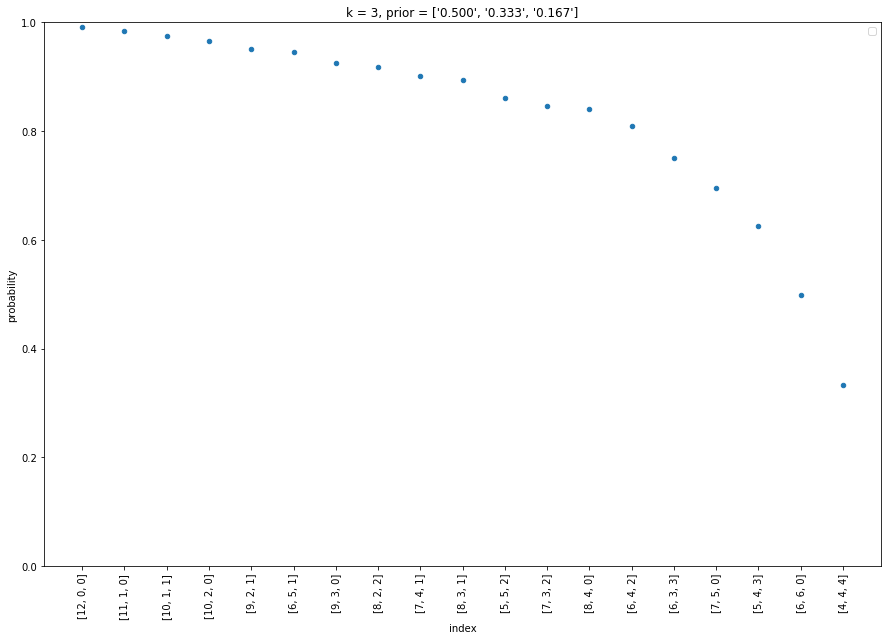

In [23]:
n = 12
k = 3
prob = [1/2, 1/3, 1/6]
norm_df = normalized_choose_post_vuln(n, k, prob)
graph_choose_normalized(n, k, prob, norm_df)

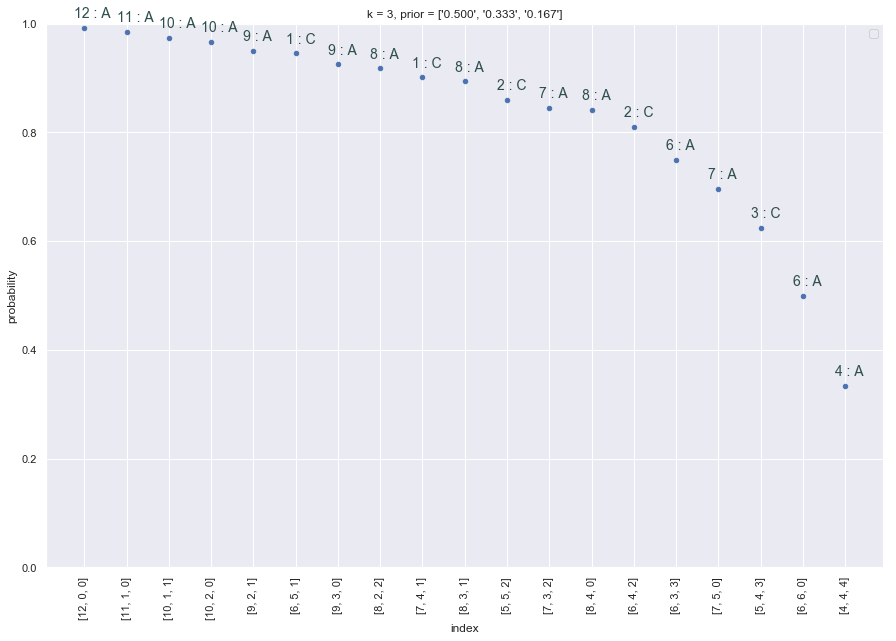

In [313]:
graph_choose_normalized_annotate(n, k, prob, norm_df)

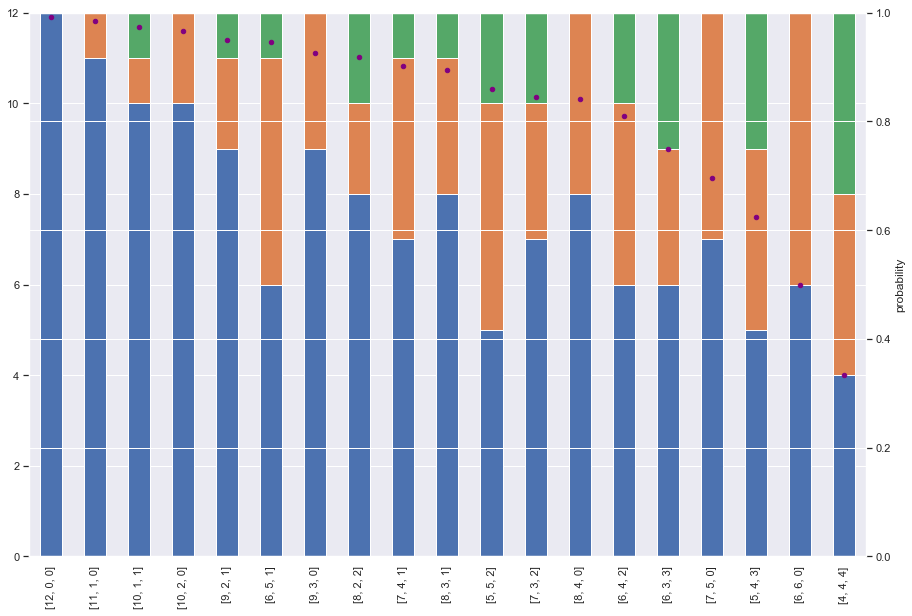

In [289]:
graph_choose_normalized_blocksize(n, k, prob, norm_df)

### n = 24, nonuniform prior

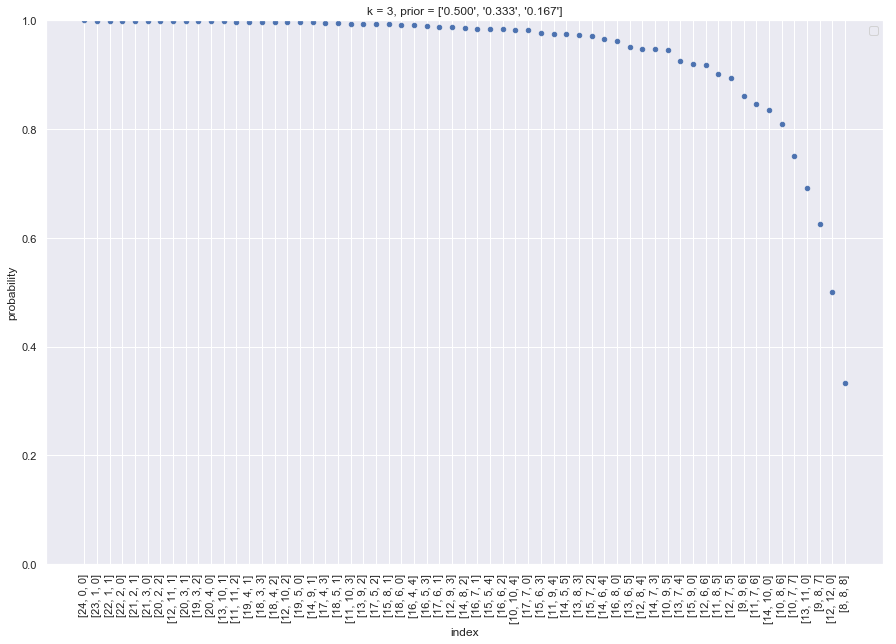

In [74]:
n = 24
k = 3
prob = [1/2, 1/3, 1/6]
norm_df = normalized_choose_post_vuln(n, k, prob)
graph_choose_normalized(n, k, prob, norm_df)

### n = 50, two priors are close

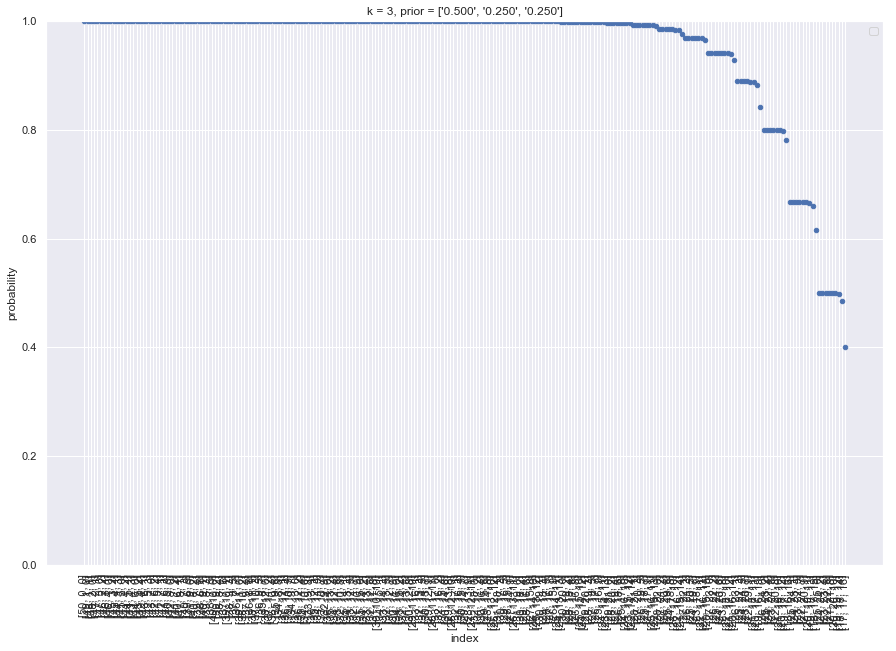

In [75]:
n = 50
k = 3
prob = [1/2, 1/4, 1/4]
close_50_prob = normalized_choose_post_vuln(n, k, prob)
graph_choose_normalized(n, k, prob, close_50_prob)

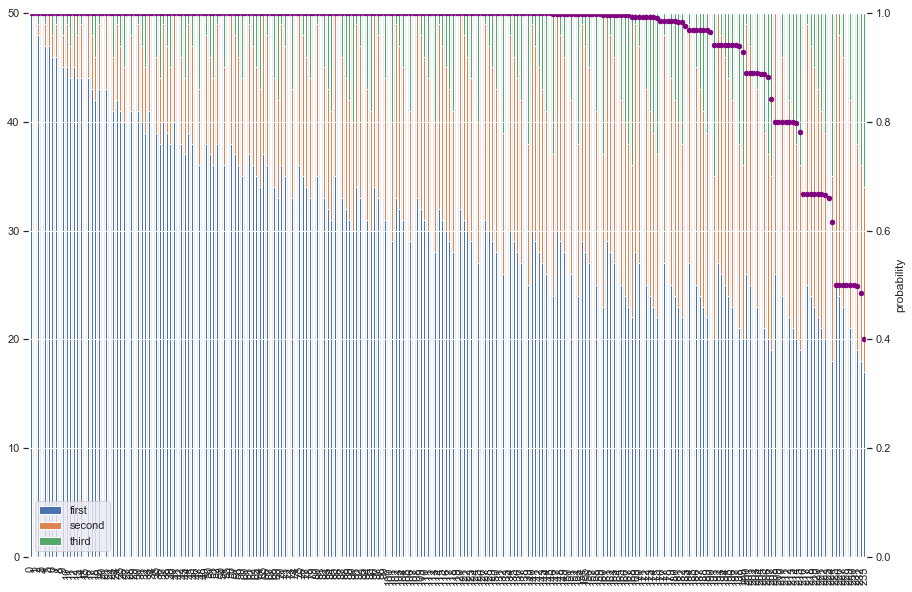

In [76]:
n = 50
k = 3
prob = [1/2, 1/4, 1/4]
graph_choose_normalized_blocksize(n, k, prob, close_50_prob)

### Zoomed in on cascading effect where probability < .99

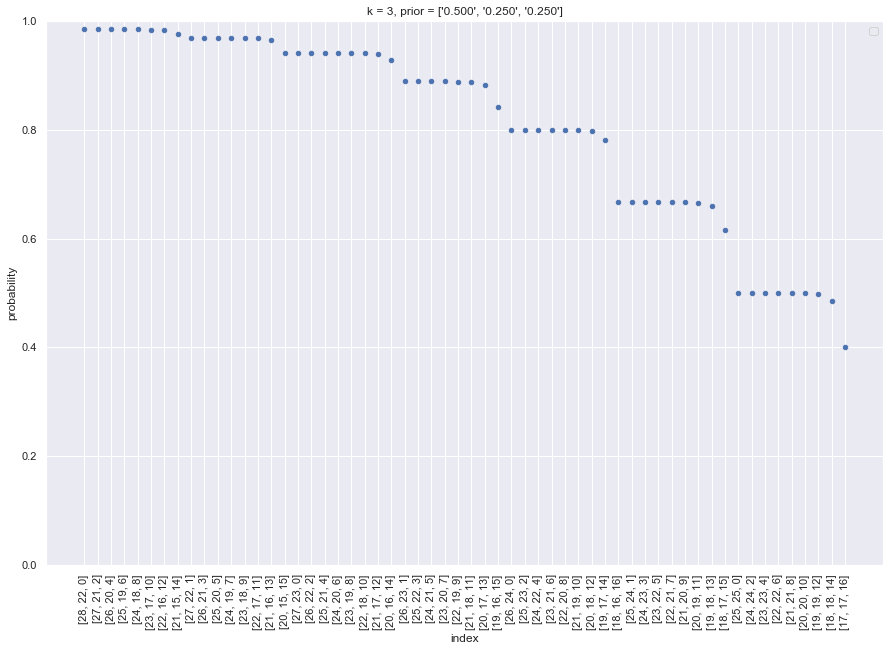

In [77]:
zoom_close_50 = close_50_prob[(close_50_prob['probability'] < .99)]
graph_choose_normalized(n, k, prob, zoom_close_50)

### n = 12, uniform prior

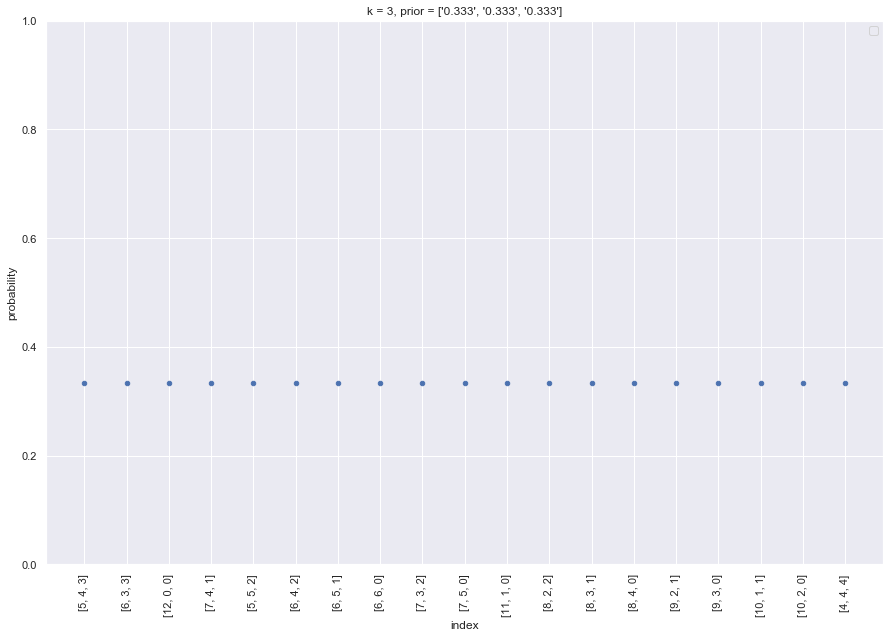

In [78]:
n =12
k = 3
prob = [1/3, 1/3, 1/3]
norm_uni = normalized_choose_post_vuln(n, k, prob)
graph_choose_normalized(n, k, prob, norm_uni)

# Posterior G-Vuln Functions and Graphs

***forced_and_choose_post_vuln***: most important function to calculate the posterior vulnerability for both versions of the gain function 

The following image outlines the flow of the program. Functions are represented as rectangles while variables are ovals. 

The light purple backgrounds indicates functions that occur in the per-integer partition loop.

The black variables are the per-integer partition posterior vulnerability values for both gain functions.

<img src="forced_and_choose_post_vuln.png" alt="drawing" width="600"/>

In [79]:
logging.basicConfig(level=logging.DEBUG)

In [11]:
def forced_and_choose_post_vuln_df(n, k, pi):
    data = []
    forced_sum = 0
    choose_sum = 0
    pi_dict = k_dictionary(pi)
    for p in partitions(n, m=k): 
        num_index = calc_index_partitions(n,p) # p's number of index partitions
        df, int_list = type_3(p, pi_dict, k) # the probabilities of different types of the column
        logging.info('dataframe -\n {}'.format(df))
        if k == 3:
            df_g = choices_matrix(df, int_list) # the disease:block size guesses the adversary can make
        elif k == 4:
            df_g = choices_matrix_4(df, int_list)
        elif k == 5:
            df_g = choices_matrix_5(df, int_list)
        else:
            raise ValueError("k isn't 3, 4, or 5")
        logging.info('Guess Matrix -\n {}'.format(df_g))
        forced_per_p = forced_max(df_g, num_index, n)
        forced_sum = forced_sum + forced_per_p # the post vuln for forced gain
        choose_per_p, block_size, disease = choose_max(df_g)#posterior vuln for 1 p and best guess
        logging.info('post vuln -\n {}'.format(choose_per_p))
        logging.info('block size -\n {}'.format(block_size))
        logging.info('disease -\n {}'.format(disease))
        logging.info('num_index -\n {}'.format(num_index))
        weighted = num_index * choose_per_p
        choose_sum = choose_sum + weighted
        int_list += [0] * (3 - len(int_list)) #pad int_list
        p_guess = {'partition': int_list, 'num_index': num_index, 'choose_per_p': choose_per_p, 'weighted': weighted,  'block': block_size, 'disease': disease, 'forced_per_p':forced_per_p, 'first': int_list[0], 'second': int_list[1], 'third': int_list[2]}
        data.append(p_guess)
    partition_df = pda.DataFrame(data = data)
    prob_df = partition_df.sort_values(by=['weighted'], ascending=False).reset_index(drop=True)
    return forced_sum, choose_sum, prob_df

In [15]:
forced, choose, df = forced_and_choose_post_vuln_df(100, 3, [1/2, 1/3, 1/6])
df

,block,choose_per_p,disease,first,forced_per_p,num_index,partition,second,third,weighted
0,16,1.8906808882e-44,c,50,9.3801274614e-03,4.9675767351e+41,"[50, 34, 16]",34,16,9.3921023936e-03
1,17,9.4486143234e-45,c,50,9.3795148541e-03,9.9351534702e+41,"[50, 33, 17]",33,17,9.3873433384e-03
2,16,2.8336262736e-44,c,51,9.3788769823e-03,3.3117178234e+41,"[51, 33, 16]",33,16,9.3841706350e-03
3,17,6.3070597446e-45,c,49,9.1975499642e-03,1.4610519809e+42,"[49, 34, 17]",34,17,9.2149421336e-03
4,17,1.4164937956e-44,c,51,9.1028464972e-03,6.4286287160e+41,"[51, 32, 17]",32,17,9.1061126906e-03
5,16,1.2628489841e-44,c,49,8.9361654974e-03,7.0965381930e+41,"[49, 35, 16]",35,16,8.9618560479e-03
6,16,4.2488427045e-44,c,52,8.9274686130e-03,2.1016670802e+41,"[52, 32, 16]",32,16,8.9296528413e-03
7,15,5.6691685941e-44,c,51,8.8275407689e-03,1.5584554463e+41,"[51, 34, 15]",34,15,8.8351466715e-03
8,18,3.1511348136e-45,c,49,8.6856808799e-03,2.7597648528e+42,"[49, 33, 18]",33,18,8.6963911052e-03
9,15,8.4989627737e-44,c,52,8.6570569580e-03,1.0189900995e+41,"[52, 33, 15]",33,15,8.6603589225e-03


In [16]:
df.sum(axis = 0)

block                                                       39101
choose_per_p                                      3.775262901e-30
disease         ccccccccccccccccccccccccccaccacccccacccacccaac...
first                                                       54315
forced_per_p                                         0.9689522738
num_index                                         8.589625346e+46
partition       [50, 34, 16, 50, 33, 17, 51, 33, 16, 49, 34, 1...
second                                                      24412
third                                                        9673
weighted                                             0.9998186841
dtype: object

In [28]:
a_sum = df[(df.disease == 'a')].sum()['weighted']
print(a_sum)

0.38203732281664365


In [29]:
c_sum = df[(df.disease == 'c')].sum()['weighted']
print(c_sum)

0.4307484567901233


In [31]:
print(a_sum / (a_sum + c_sum))

0.4700344572975633


In [32]:
print(c_sum / (a_sum + c_sum))

0.5299655427024366


In [12]:
def forced_and_choose_post_vuln(n, k, pi):
    forced_sum = 0
    choose_sum = 0
    pi_dict = k_dictionary(pi)
    for p in partitions(n, m=k): 
        num_index = calc_index_partitions(n,p) # p's number of index partitions
        df, int_list = type_3(p, pi_dict, k) # the probabilities of different types of the column
        logging.info('dataframe -\n {}'.format(df))
        if k == 3:
            df_g = choices_matrix(df, int_list) # the disease:block size guesses the adversary can make
        elif k == 4:
            df_g = choices_matrix_4(df, int_list)
        elif k == 5:
            df_g = choices_matrix_5(df, int_list)
        else:
            raise ValueError("k isn't 3, 4, or 5")
        logging.info('Guess Matrix -\n {}'.format(df_g))
        forced_per_p = forced_max(df_g, num_index, n)
        forced_sum = forced_sum + forced_per_p # the post vuln for forced gain
        choose_per_p, block_size, disease = choose_max(df_g)#posterior vuln for 1 p and best guess
        logging.info('post vuln -\n {}'.format(choose_per_p))
        logging.info('block size -\n {}'.format(block_size))
        logging.info('disease -\n {}'.format(disease))
        logging.info('num_index -\n {}'.format(num_index))
        weighted = num_index * choose_per_p
        choose_sum = choose_sum + weighted  
    return forced_sum, choose_sum

In [25]:
n = 12
k = 3
forced_4, choose_4 = forced_and_choose_post_vuln(n, k, [1/2, 1/3, 1/6])
print("k = %s" % k)
print("Choose Posterior vulnerability for n = %s " % n)
print(choose_4)
print("Forced Posterior vulnerability for n = %s " % n)
print(forced_4)

k = 3
Choose Posterior vulnerability for n = 12 
0.8127857796067669
Forced Posterior vulnerability for n = 12 
0.679779534925443


In [ ]:
logging.disabled = True

## Posterior G-Vulnerability Graph Functions

The posterior g-vuln for k = 4 and k = 5 take a while to compute. To save time, the below code can read it from file and graph that data instead of calculating the values again.

In [13]:
def choose_and_forced_prior_post(n_range, k, probs):
    choose_post_vs = []
    forced_post_vs = []
    prior_vs = []
    
    probs.sort(reverse=True) 
    prior_val=probs[0] # sets the line for prior vuln
    for i in range(n_range):
        forced, choose = forced_and_choose_post_vuln(i+1, k, probs)
        choose_post_vs.append(choose)
        forced_post_vs.append(forced)
        prior_vs.append(prior_val)
    df = pda.DataFrame(
        {'prior':prior_vs,
         'forced posterior': forced_post_vs,
         'choose posterior': choose_post_vs
        }
    )
    return df

In [25]:
def graph_it_prior_choose_forced(n_range, k, probs, df):
    x = [i+1 for i in range(n_range)]
    
    plt.plot(x, 'prior', 
             data=df, 
             label="prior")
    plt.plot(x, 'choose posterior', 
             data=df, 
             label="posterior, free")
    plt.plot(x, 'forced posterior', 
             data=df, 
             label="posterior, forced")
    plt.xlabel('n values')
    plt.ylabel('g-vulnerability')
    plt.ylim(bottom=0, top = 1)
    
    # title rounds the prior
    format_probs = ['%.3f' % prob for prob in probs]
    plt.title(r'Single Index g-Vulnerability, $\delta  = \left(\frac{1}{3}, \frac{1}{3}, \frac{1}{3} \right)$',  fontsize = 16, y=1.02)
    plt.legend()
    plt.show()
    plt.close()

### K = 3

In [33]:
df_non_uni = choose_and_forced_prior_post(100, 3, [1/2, 1/3, 1/6])

In [251]:
df_non_uni.to_csv (r'data\df_non_uni.csv', index = None, header=True) 

In [15]:
df_non_uni_csv = pda.read_csv('data\df_non_uni.csv')

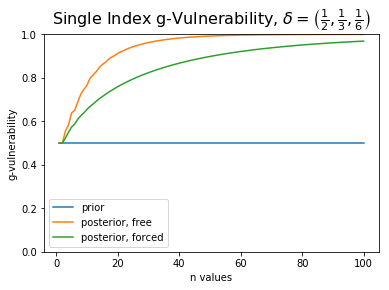

In [24]:
graph_it_prior_choose_forced(100, 3, [1/2, 1/3, 1/6], df_non_uni_csv)

In [30]:
non_ten = df_non_uni_csv.head(10)

In [60]:
non_ten

,prior,forced posterior,choose posterior
0,0.5,0.5000000000,0.5000000000
1,0.5,0.5000000000,0.5000000000
2,0.5,0.5231481481,0.5555555556
3,0.5,0.5501543210,0.5833333333
4,0.5,0.5736882716,0.6388888889
5,0.5,0.5875342936,0.6504629630
6,0.5,0.6095750457,0.6890432099
7,0.5,0.6254197388,0.7250514403
8,0.5,0.6392347021,0.7469564472
9,0.5,0.6547978162,0.7664984139


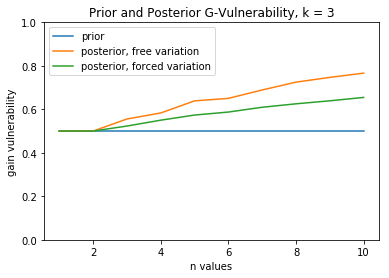

In [59]:
graph_it_prior_choose_forced(10, 3, [1/2, 1/3, 1/6], non_ten)

In [44]:
df_uni = choose_and_forced_prior_post(100, 3, [1/3, 1/3, 1/3])

In [250]:
df_uni.to_csv(r'data\df_uni.csv', index = None, header=True) 

In [19]:
df_uni_csv = pda.read_csv('data\df_uni.csv')

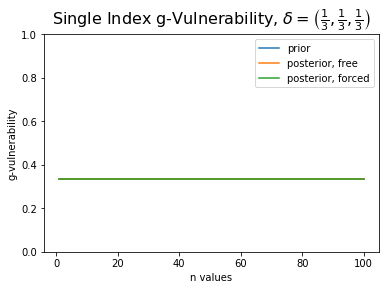

In [26]:
graph_it_prior_choose_forced(100, 3, [1/3, 1/3, 1/3], df_uni_csv)

In [45]:
df_two_same = choose_and_forced_prior_post(100, 3, [1/2, 1/4, 1/4])

In [247]:
df_two_same.to_csv(r'data\df_two_same.csv', index = None, header=True) 

In [34]:
df_two_same_csv = pda.read_csv('data\df_two_same.csv')

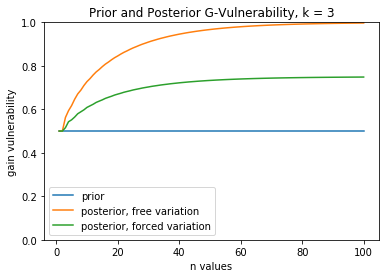

In [61]:
graph_it_prior_choose_forced(100, 3, [1/2, 1/4, 1/4], df_two_same_csv)

In [46]:
df_two_close = choose_and_forced_prior_post(100, 3, [.5, .26, .24])

In [252]:
df_two_close.to_csv(r'data\df_two_close.csv', index=None, header=True) 

In [36]:
df_two_close_csv = pda.read_csv('data\df_two_close.csv')

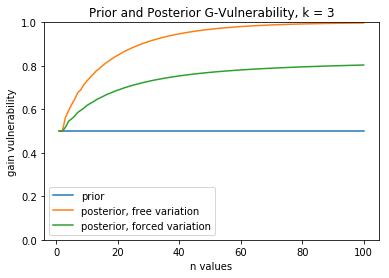

In [62]:
graph_it_prior_choose_forced(100, 3, [.5, .26, .24], df_two_close_csv)

### K = 4
Note: n = 50 to save computation time

In [42]:
n = 100
k = 4
probs = [1/2, 1/3, 1/8, 1/24]

In [188]:
df_non_uni_4 = choose_and_forced_prior_post(n, k, probs)

In [253]:
df_non_uni_4.to_csv(r'data\df_non_uni_4.csv', index=None, header=True) 

In [43]:
df_non_uni_4_csv = pda.read_csv('data\df_non_uni_4.csv')

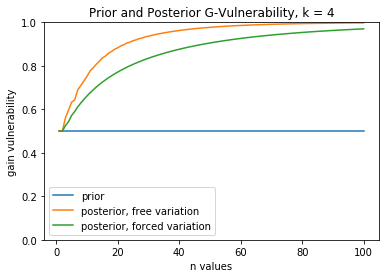

In [63]:
graph_it_prior_choose_forced(n, k, probs, df_non_uni_4_csv)

In [45]:
probs = [1/2, 1/6, 1/6, 1/6]

In [194]:
df_two_same_4 = choose_and_forced_prior_post(n, k, probs)

In [254]:
df_two_same_4.to_csv(r'data\df_two_same_4.csv', index = None, header=True) 

In [46]:
df_two_same_4_csv = pda.read_csv('data\df_two_same_4.csv')

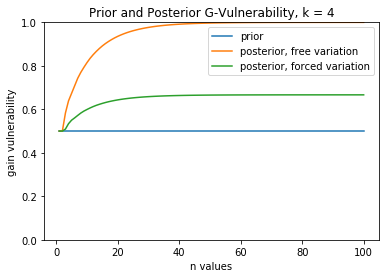

In [64]:
graph_it_prior_choose_forced(n, k, probs, df_two_same_4_csv)

In [48]:
probs = [1/4, 1/4, 1/4, 1/4]

In [197]:
df_uni_4 = choose_and_forced_prior_post(20, k, probs)

In [255]:
df_uni_4.to_csv(r'data\df_uni_4.csv', index=None, header=True) 

In [49]:
df_uni_4_csv = pda.read_csv('data\df_uni_4.csv')

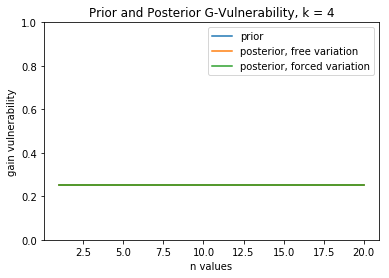

In [65]:
graph_it_prior_choose_forced(20, k, probs, df_uni_4_csv)

### K = 5

In [104]:
df_non_uni_5 = choose_and_forced_prior_post(50, 5, [13/25, 5/25, 4/25, 2/25, 1/25])

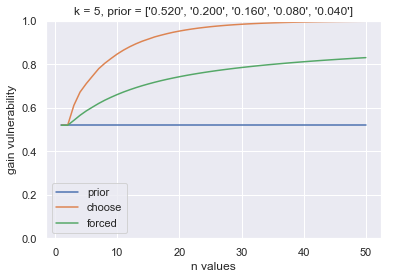

In [105]:
graph_it_prior_choose_forced(50, 5, [13/25, 5/25, 4/25, 2/25, 1/25], df_non_uni_5)

In [106]:
df_uni_5 = choose_and_forced_prior_post(30, 5, [1/5, 1/5, 1/5, 1/5, 1/5])

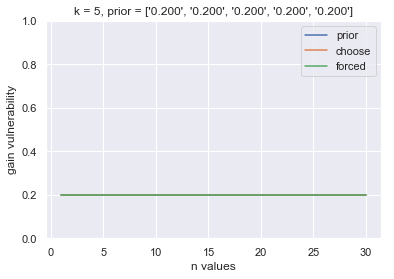

In [107]:
graph_it_prior_choose_forced(30, 5, [1/5, 1/5, 1/5, 1/5, 1/5], df_uni_5)

---
#### Old graphs and not-in-use functions

In [19]:
def graph_2_8(k, probs):
    fig, ax = plt.subplots(2, 3, sharey='col', figsize=(15, 15)) 
    i = 0
    for n in range(2, 8):
        logging.info('starting with n =  -\n {}'.format(n))
        logging.info('k: -\n'.format(k))
        df = normalized_choose_post_vuln(n, k, prob)
        logging.info('dataframe -\n {}'.format(df))
        thisax =  ax[i // 3][i % 3]
        logging.info('this axis -\n {}'.format(thisax))
        df.reset_index().plot.scatter(x='index', 
                    y='probability', ax = thisax)
        i = i + 1
        #annotate with disease and block choice
        for  ind, v in df.iterrows():
            dis = to_str(df['disease'][ind])
            block = to_str(df['block'][ind])
            num_index = to_str(df['num_index'][ind])
            choice = dis + ', ' + block
            thisax.annotate(choice,
                        xy=(ind, v['probability']),
                        xytext=(-10,10), textcoords='offset points',
                        family='sans-serif', fontsize=12, color='darkslategrey')
            ## annotate with number of index partitions
            thisax.annotate(num_index,
                        xy=(ind, v['probability']),
                        xytext=(-10,-15), textcoords='offset points',
                        family='sans-serif', fontsize=12, color='darkslategrey')
        #format graph
        thisax.set_xticks(df.index)
        thisax.set_xticklabels(df['partition'], rotation=90)
        thisax.set_ylim(bottom=0, top = 1)
        logging.info('finished with n:  -\n {}'.format(n))
        del df
        logging.info('deleted dataframe')
    
    ## title rounds the prior
    #format_probs = ['%.3f' % prob for prob in probs]
    #plt.title(f'k = {k}, prior = {format_probs}')
    plt.legend()
    plt.show()
    plt.close()

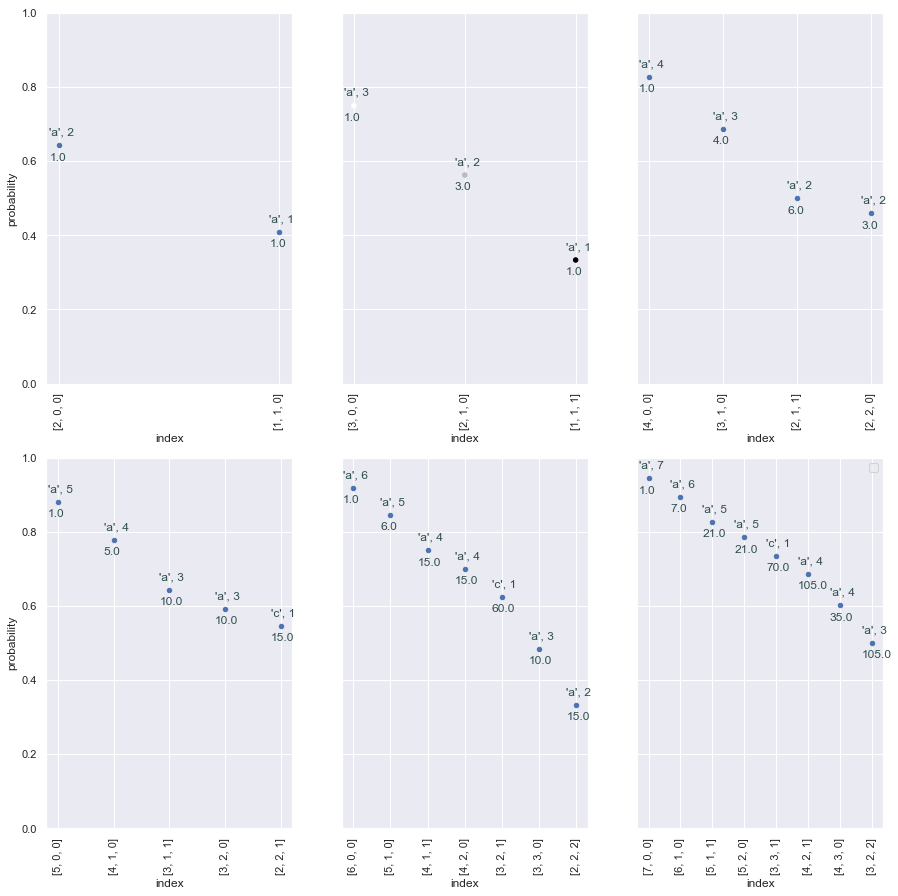

In [255]:
k = 3
probs = [1/2, 1/3, 1/6]
graph_2_8(k, probs)

In [38]:
def color_plot_vuln(df):
    fig, ax = plt.subplots() # to show xtick labels
    df.reset_index().plot.scatter(x='index', 
                y='weighted',
                c = 'contribution', # the color map scale
                colormap='winter_r',
                ax = ax)
    plt.xticks(df.index, df['partition'], rotation=90)
    plt.title("Individual and Weighted Vulnerability Per Integer Partition")
    plt.show()
##Graph options w/o colormap
#choices_df.plot(x='partition', 
#                y='weighted',
#                style='o-')
#plt.xticks(choices_df.index, choices_df['partition'], rotation=90)
#plt.show()

<IPython.core.display.Javascript object>


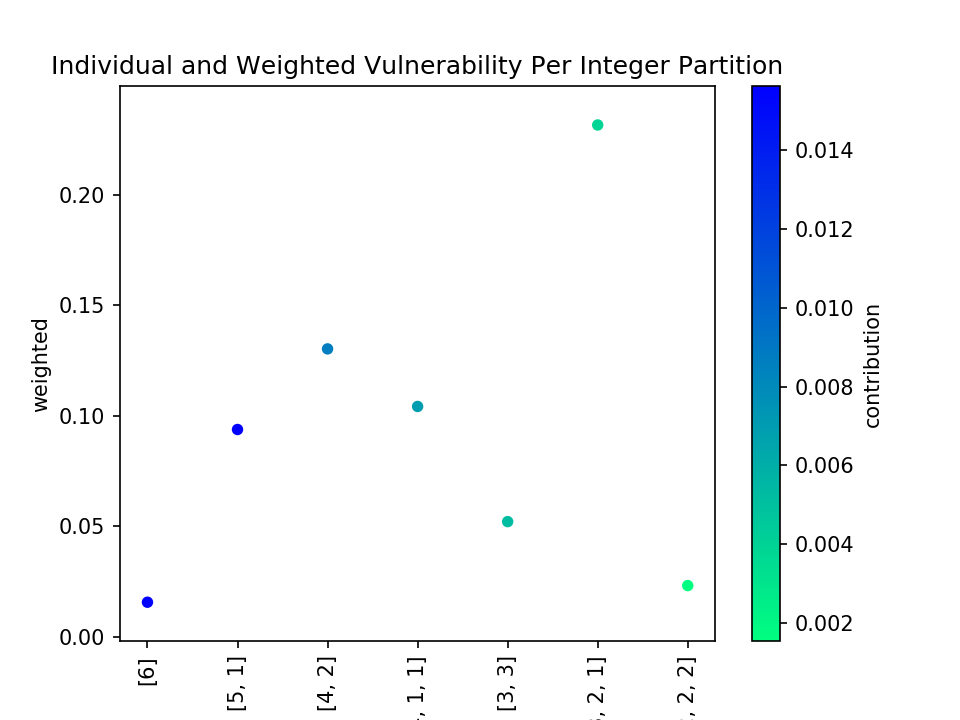

In [52]:
color_plot_vuln(choices_df)

In [25]:
def graph_it_prior_post(n_range, k, probs, df):
    x = [i+1 for i in range(n_range)]
    y_posterior = df["posterior"].iloc[-1] # saves last posterior y
    
    plt.plot(x, 'prior', 
             data=df, 
             linestyle='--', 
             label="prior")
    plt.plot(x, 'posterior', 
             data=df, 
             marker='', 
             label="posterior")
    plt.xlabel('n values')
    plt.ylabel('gain vulnerability')
    plt.ylim(bottom=0, top = 1)
    
     # orange dot for last y posterior vulnerability
    plt.annotate('%.3f' % y_posterior, 
                 xy=[n_range, y_posterior],
                 xytext=(-20, -15),
                 textcoords='offset points')
    plt.plot(n_range, y_posterior, 
             marker = 'o', 
             markerfacecolor='orange',
             markeredgecolor='orange')
    
    # title rounds the prior
    format_probs = ['%.3f' % prob for prob in probs]
    plt.title(f'k = {k}, prior = {format_probs}')
    
    plt.show()

In [20]:
def choose_prior_post(n_range, k, probs):
    post_vs = []
    prior_vs = []
    probs.sort(reverse=True) 
    prior_val=probs[0] # sets the line for prior vuln
    for i in range(n_range):
        post_vs.append(choose_post_vuln(i+1, k, probs))
        prior_vs.append(prior_val)
    df = pd.DataFrame(
        {'prior':prior_vs,
         'posterior':post_vs
        }
    )
    graph_it_prior_post(n_range, k, probs, df)

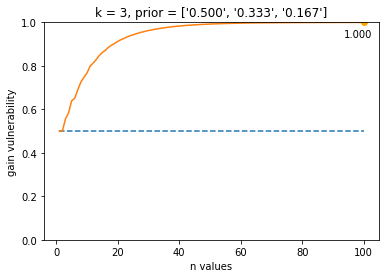

In [26]:
choose_prior_post(100, 3, [1/2, 1/3, 1/6])

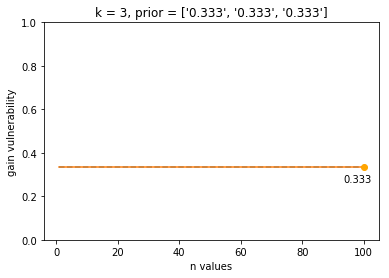

In [27]:
choose_prior_post(100, 3, [1/3, 1/3, 1/3])

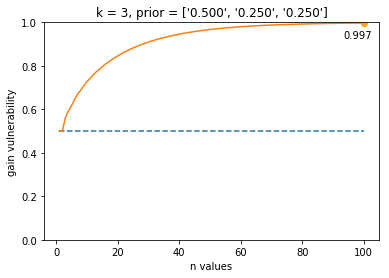

In [28]:
choose_prior_post(100, 3, [1/2, 1/4, 1/4])

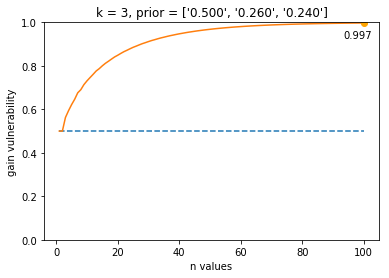

In [29]:
choose_prior_post(100, 3, [1/2, .24, .26])

---
***reduce_choices()*** reduces the size of the df_g matrix by removing equal choices

Input:
- df_g, the matrix containing all of the possible choices
- p, the integer partition dictionary

Output:
- df_reduced_guess, a dataframe that indicates the possible unique choices an adversary choice make given an integer partition

**Note: Not currently in use**

In [9]:
def reduce_choices(df_g, p):
    data = []
    # if p[k] (multiplicity) >1, only take one row
    for k in p.keys(): # for every unique integer in p, copy a row in df_guess that matches the int
        if p[k] > 1: # choose first example if >1
            data.append(df_g.loc[k].iloc[0])
        else:
            data.append(df_g.loc[k]) #copy the row
    df_reduced_guess = pda.DataFrame(data = data)
    return df_reduced_guess

In [16]:
my_reduced_df = reduce_choices(my_df_guess, partition_test)
my_reduced_df.head()

,a,b,c
4,0.006944,0.002058,0.000257
1,0.001157,0.003601,0.004501


In [14]:
my_reduced_df.sum(axis=1)

3    0.006173
2    0.006173
1    0.006173
dtype: float64